# Exploratory data analysis of TCGA gen expression and CCLE - IC50 

In [1]:
#%load_ext autoreload
#%autoreload 2
import os
#os.environ["CUDA_VISIBLE_DEVICES"]=""

import pandas as pd
import numpy as np
import os, gc

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from os.path import getsize

from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.train import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.layers import *
from fastai.text import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [46]:
#Normalization

CCLE_scaler = MinMaxScaler() #StandardScaler() #DummyScaler()#
TCGA_scaler = MinMaxScaler() #StandardScaler() #DummyScaler()#
drug_scaler = ""#MinMaxScaler() #StandardScaler() #DummyScaler() #in paper it was not normalized




In [3]:
def try_read_feather(fn, **kwargs):
    fn_feather = fn.replace('.csv','.feather')
    if os.path.exists(fn_feather):
        df = pd.read_feather(fn_feather)
        df.set_index('index', inplace=True)
        del df.index.name
        return df
    df = pd.read_csv(fn,**kwargs)
    df.reset_index().to_feather(fn_feather)
    return df

In [4]:
#import CCLE data
E_CCLE = try_read_feather('E_CCLE.csv', index_col=0)
M_CCLE = try_read_feather('M_CCLE.csv', index_col=0)


In [5]:
E_TCGA = try_read_feather('E_TCGA.csv',index_col=0)

In [6]:
M_TCGA = try_read_feather('M_TCGA.csv',index_col=0)

In [7]:
IC50 = try_read_feather('IC50_CCLE_author.csv',index_col=0)

In [8]:
M_sco_TCGA = try_read_feather('M_scored_TCGA.csv',index_col=0)
M_sco_CCLE = try_read_feather('M_scored_CCLE.csv',index_col=0)

In [9]:
E_CCLE = E_CCLE.transpose()
E_CCLE.head()

ZBTB7A       CRH   TMEM74B    ERLIN2    ZBTB43      POLL  \
NIHOVCAR3  2.765535  0.163499  0.863938  4.254745  3.235727  4.941576   
HL60       2.250962  0.176323  0.042644  2.521051  1.613532  4.323370   
CACO2      2.063503  0.056584  2.467279  4.303781  2.430285  3.713696   
HEL        2.490570  0.000000  1.454176  4.211791  2.384050  4.375039   
HEL9217    2.232661  0.028569  1.063503  4.180307  2.427606  4.207893   

           SPANXN1     CPNE7  OR8B3   PKHD1L1  ...  C11orf87    CUEDC2  \
NIHOVCAR3      0.0  0.925999    0.0  0.189034  ...  0.014355  6.524346   
HL60           0.0  0.097611    0.0  0.000000  ...  0.000000  5.744430   
CACO2          0.0  4.270529    0.0  0.000000  ...  0.014355  4.603478   
HEL            0.0  0.084064    0.0  0.014355  ...  0.028569  6.476058   
HEL9217        0.0  0.432959    0.0  0.000000  ...  0.014355  6.458284   

             ZNF799     FOXR1     BMPER     LAMA1     EPS15      GSC2  \
NIHOVCAR3  0.879706  0.000000  4.386121  4.013462  4.094236  0.042644   
HL60       1.570463  0.000000  0.137504  0.084064  3.267536  0.000000   
CACO2      2.189034  0.000000  0.356144  2.887525  3.612352  0.000000   
HEL        1.214125  0.028569  0.056584  0.014355  5.934752  0.000000   
HEL9217    1.811471  0.000000  0.111031  0.014355  6.020147  0.000000   

            TP53BP1      MGAM  
NIHOVCAR3  5.428611  0.042644  
HL60       3.026800  0.748461  
CACO2      3.807355  0.356144  
HEL        4.384741  0.422233  
HEL9217    4.958379  0.584963  

[5 rows x 17947 columns]

In [10]:
M_CCLE = M_CCLE.transpose()
M_CCLE.head()

ZBTB7A  CRH  TMEM74B  ERLIN2  ZBTB43  POLL  SPANXN1  CPNE7  OR8B3  \
127399      0.0  0.0      0.0     0.0     0.0   0.0      0.0    0.0    0.0   
201T        0.0  0.0      0.0     0.0     0.0   0.0      0.0    0.0    0.0   
22RV1       1.0  0.0      0.0     0.0     0.0   0.0      0.0    0.0    0.0   
2313287     0.0  0.0      0.0     0.0     0.0   0.0      0.0    0.0    0.0   
253J        0.0  0.0      0.0     0.0     0.0   0.0      0.0    0.0    0.0   

         PKHD1L1  ...  C11orf87  CUEDC2  ZNF799  FOXR1  BMPER  LAMA1  EPS15  \
127399       0.0  ...       0.0     0.0     0.0    0.0    0.0    0.0    0.0   
201T         0.0  ...       0.0     0.0     0.0    0.0    0.0    0.0    0.0   
22RV1        1.0  ...       0.0     0.0     0.0    0.0    0.0    2.0    0.0   
2313287      4.0  ...       0.0     0.0     0.0    0.0    0.0    2.0    0.0   
253J         0.0  ...       0.0     0.0     0.0    0.0    0.0    0.0    0.0   

         GSC2  TP53BP1  MGAM  
127399    0.0      0.0   0.0  
201T      0.0      0.0   1.0  
22RV1     0.0      1.0   0.0  
2313287   0.0      3.0   2.0  
253J      0.0      0.0   0.0  

[5 rows x 18528 columns]

In [11]:
M_TCGA = M_TCGA.transpose()
M_TCGA.head()

ZBTB7A  CRH  TMEM74B  ERLIN2  ZBTB43  \
0004d251-3f70-4395-b175-c94c2f5b1b81     0.0  0.0      0.0     0.0     0.0   
000d566c-96c7-4f1c-b36e-fa2222467983     0.0  0.0      0.0     0.0     0.0   
0011a67b-1ba9-4a32-a6b8-7850759a38cf     0.0  0.0      0.0     0.0     0.0   
001887aa-36d0-463f-8bca-dec7043b4f2e     0.0  0.0      0.0     0.0     0.0   
001944e5-af34-4061-9c09-bb9ea346f6fd     0.0  0.0      0.0     0.0     0.0   

                                      POLL  SPANXN1  CPNE7  OR8B3  PKHD1L1  \
0004d251-3f70-4395-b175-c94c2f5b1b81   0.0      0.0    0.0    0.0      0.0   
000d566c-96c7-4f1c-b36e-fa2222467983   0.0      0.0    0.0    0.0      0.0   
0011a67b-1ba9-4a32-a6b8-7850759a38cf   0.0      0.0    0.0    0.0      0.0   
001887aa-36d0-463f-8bca-dec7043b4f2e   0.0      0.0    0.0    0.0      0.0   
001944e5-af34-4061-9c09-bb9ea346f6fd   0.0      0.0    0.0    0.0      0.0   

                                      ...  C11orf87  CUEDC2  ZNF799  FOXR1  \
0004d251-3f70-4395-b175-c94c2f5b1b81  ...       0.0     0.0     0.0    0.0   
000d566c-96c7-4f1c-b36e-fa2222467983  ...       0.0     0.0     0.0    0.0   
0011a67b-1ba9-4a32-a6b8-7850759a38cf  ...       0.0     0.0     0.0    0.0   
001887aa-36d0-463f-8bca-dec7043b4f2e  ...       0.0     0.0     0.0    0.0   
001944e5-af34-4061-9c09-bb9ea346f6fd  ...       0.0     0.0     0.0    0.0   

                                      BMPER  LAMA1  EPS15  GSC2  TP53BP1  MGAM  
0004d251-3f70-4395-b175-c94c2f5b1b81    0.0    0.0    0.0   0.0      0.0   0.0  
000d566c-96c7-4f1c-b36e-fa2222467983    0.0    0.0    0.0   0.0      0.0   0.0  
0011a67b-1ba9-4a32-a6b8-7850759a38cf    0.0    0.0    0.0   0.0      0.0   0.0  
001887aa-36d0-463f-8bca-dec7043b4f2e    0.0    0.0    0.0   0.0      0.0   0.0  
001944e5-af34-4061-9c09-bb9ea346f6fd    0.0    0.0    0.0   0.0      0.0   0.0  

[5 rows x 18528 columns]

In [12]:
E_TCGA = E_TCGA.transpose()
E_TCGA.head()

ZBTB7A      CRH   TMEM74B    ERLIN2  \
d3b7ada6-5395-4212-a921-8e97c92b605d    4.256269  0.00000  0.722542  4.252478   
065f7b7a-05ee-4728-bcfc-6095357512a6    3.670214  0.02871  4.086634  3.344838   
065f7b7a-05ee-4728-bcfc-6095357512a6.1  4.084939  0.00000  3.150595  3.671320   
c328f661-c109-4e01-b819-299a75bd4348    3.058325  0.00000  1.232706  5.463052   
ebe927e6-0a7e-4c97-ad73-f3c302cca7bc    3.124356  0.00000  2.634650  4.100191   

                                          ZBTB43      POLL   SPANXN1  \
d3b7ada6-5395-4212-a921-8e97c92b605d    2.521083  4.249446  0.000000   
065f7b7a-05ee-4728-bcfc-6095357512a6    2.508458  5.236450  0.000000   
065f7b7a-05ee-4728-bcfc-6095357512a6.1  2.963452  5.499225  0.000000   
c328f661-c109-4e01-b819-299a75bd4348    2.702668  4.407376  0.056724   
ebe927e6-0a7e-4c97-ad73-f3c302cca7bc    1.546046  4.803753  0.124460   

                                           CPNE7  OR8B3   PKHD1L1  ...  \
d3b7ada6-5395-4212-a921-8e97c92b605d    5.136277    0.0  0.201757  ...   
065f7b7a-05ee-4728-bcfc-6095357512a6    0.150686    0.0  0.956147  ...   
065f7b7a-05ee-4728-bcfc-6095357512a6.1  0.111167    0.0  0.433055  ...   
c328f661-c109-4e01-b819-299a75bd4348    0.632353    0.0  7.565331  ...   
ebe927e6-0a7e-4c97-ad73-f3c302cca7bc    3.927952    0.0  4.020564  ...   

                                        C11orf87    CUEDC2    ZNF799    FOXR1  \
d3b7ada6-5395-4212-a921-8e97c92b605d    0.042784  5.354371  2.513489  0.00000   
065f7b7a-05ee-4728-bcfc-6095357512a6    0.028710  6.134662  1.495726  0.00000   
065f7b7a-05ee-4728-bcfc-6095357512a6.1  0.000000  6.549867  1.541050  0.00000   
c328f661-c109-4e01-b819-299a75bd4348    2.241900  6.042239  1.275063  0.02871   
ebe927e6-0a7e-4c97-ad73-f3c302cca7bc    0.014498  6.548086  2.153826  0.00000   

                                           BMPER     LAMA1     EPS15  GSC2  \
d3b7ada6-5395-4212-a921-8e97c92b605d    0.356247  1.131011  3.682567   0.0   
065f7b7a-05ee-4728-bcfc-6095357512a6    1.922249  0.201757  3.712564   0.0   
065f7b7a-05ee-4728-bcfc-6095357512a6.1  2.025058  0.992862  4.061800   0.0   
c328f661-c109-4e01-b819-299a75bd4348    0.555915  2.877778  4.200036   0.0   
ebe927e6-0a7e-4c97-ad73-f3c302cca7bc    0.632353  3.662199  3.561924   0.0   

                                         TP53BP1      MGAM  
d3b7ada6-5395-4212-a921-8e97c92b605d    3.874763  0.124460  
065f7b7a-05ee-4728-bcfc-6095357512a6    4.603446  0.111167  
065f7b7a-05ee-4728-bcfc-6095357512a6.1  4.644992  0.111167  
c328f661-c109-4e01-b819-299a75bd4348    4.368048  0.000000  
ebe927e6-0a7e-4c97-ad73-f3c302cca7bc    3.488046  0.298782  

[5 rows x 17947 columns]

In [13]:
IC50 = IC50.transpose()
print(IC50.shape)
IC50.describe() #(samples, drugs)


(622, 265)


TL-2-105     TAK-715    CP466722  BMS-345541  Genentech_Cpd_10  \
count  622.000000  622.000000  622.000000  622.000000        622.000000   
mean     3.851825    4.179568    2.648195    3.096796          2.564194   
std      1.348962    1.163468    1.357494    1.189023          1.730623   
min     -3.300900    0.337790   -1.559500   -1.281300         -2.080500   
25%      3.179982    3.374443    1.770300    2.474650          1.448693   
50%      4.127273    4.180400    2.510950    3.032450          2.430800   
75%      4.802225    4.943575    3.466250    3.733850          3.852461   
max      7.131900    7.270100    6.421600    6.590200          6.788900   

       GSK429286A  Ruxolitinib   SB-715992     ZSTK474  KIN001-102  ...  \
count  622.000000   622.000000  622.000000  622.000000  622.000000  ...   
mean     4.775895     3.988149   -1.681601    1.064734    2.600120  ...   
std      1.196296     0.957125    1.766192    1.621243    1.477692  ...   
min     -1.231900    -3.894000   -5.881400   -4.795500   -1.946800  ...   
25%      4.039975     3.650225   -3.081100    0.099268    1.703650  ...   
50%      5.026100     4.130850   -1.589500    1.082200    2.660334  ...   
75%      5.614975     4.544700   -0.203313    2.086386    3.472250  ...   
max      7.723000     6.402000    2.639200    5.416200    6.610200  ...   

       SalubriNaN   Dasatinib     XMD8-85  Roscovitine   Lapatinib  \
count  622.000000  622.000000  622.000000   622.000000  622.000000   
mean     4.134092    2.308223    3.609585     4.296905    3.472246   
std      1.104377    2.298384    1.309004     1.047221    1.284756   
min      0.805350   -6.875200   -0.555480     1.608963   -3.465800   
25%      3.319531    1.728125    2.730083     3.515567    2.700039   
50%      4.154797    2.693543    3.701829     4.334692    3.449514   
75%      4.923978    3.594486    4.449912     5.025206    4.209411   
max      7.530984    7.188214    7.528620     7.526581    7.421676   

       Cyclopamine      VX-680   JW-7-52-1   Erlotinib   Rapamycin  
count   622.000000  622.000000  622.000000  622.000000  622.000000  
mean      4.618005    2.561507    1.268788    3.504453    1.162873  
std       0.982353    1.933500    2.665416    1.340374    3.156771  
min       1.614506   -4.120200   -4.962900   -3.128400   -8.740200  
25%       4.038282    1.771375   -0.840815    2.750156   -1.439800  
50%       4.685072    2.864168    2.103007    3.462252    2.252524  
75%       5.279645    3.738891    3.090705    4.298803    3.389612  
max       7.538469    7.198368    6.569982    7.192988    7.207537  

[8 rows x 265 columns]

In [14]:
#IC50 = IC50.transpose()
#IC50.describe()

In [15]:
M_sco_TCGA = M_sco_TCGA.transpose()
M_sco_TCGA.head()

MFSD9  CASD1  NDST4  POSTN  MFAP5  \
0004d251-3f70-4395-b175-c94c2f5b1b81    0.0    0.0    0.0    0.0    0.0   
000d566c-96c7-4f1c-b36e-fa2222467983    0.0    0.0    0.0    0.0    0.0   
0011a67b-1ba9-4a32-a6b8-7850759a38cf    0.0    0.0    0.0    0.0    0.0   
001887aa-36d0-463f-8bca-dec7043b4f2e    0.0    0.0    0.0    0.0    0.0   
001944e5-af34-4061-9c09-bb9ea346f6fd    0.0    0.0    0.0    0.0    0.0   

                                      LOXHD1  FAM189A2  BMP1  STXBP4  SLC26A3  \
0004d251-3f70-4395-b175-c94c2f5b1b81     0.0       0.0   0.0     0.0      0.0   
000d566c-96c7-4f1c-b36e-fa2222467983     0.0       0.0   0.0     0.0      0.0   
0011a67b-1ba9-4a32-a6b8-7850759a38cf     0.0       0.0   0.0     0.0      0.0   
001887aa-36d0-463f-8bca-dec7043b4f2e     0.0       0.0   0.0     0.0      0.0   
001944e5-af34-4061-9c09-bb9ea346f6fd     0.0       0.0   0.0     0.0      0.0   

                                      ...  FARS2  HPD  PRAF2  DYNC2LI1  \
0004d251-3f70-4395-b175-c94c2f5b1b81  ...    0.0  0.0    0.0       0.0   
000d566c-96c7-4f1c-b36e-fa2222467983  ...    0.0  0.0    0.0       0.0   
0011a67b-1ba9-4a32-a6b8-7850759a38cf  ...    0.0  0.0    0.0       0.0   
001887aa-36d0-463f-8bca-dec7043b4f2e  ...    0.0  0.0    0.0       0.0   
001944e5-af34-4061-9c09-bb9ea346f6fd  ...    0.0  0.0    0.0       0.0   

                                      C20orf85  SLC4A11  DDB2  NBPF1  TEX264  \
0004d251-3f70-4395-b175-c94c2f5b1b81       0.0      0.0   0.0    0.0     0.0   
000d566c-96c7-4f1c-b36e-fa2222467983       0.0      0.0   0.0    0.0     0.0   
0011a67b-1ba9-4a32-a6b8-7850759a38cf       0.0      0.0   0.0    0.0     0.0   
001887aa-36d0-463f-8bca-dec7043b4f2e       0.0      0.0   0.0    0.0     0.0   
001944e5-af34-4061-9c09-bb9ea346f6fd       0.0      0.0   0.0    0.0     0.0   

                                      TIGD3  
0004d251-3f70-4395-b175-c94c2f5b1b81    0.0  
000d566c-96c7-4f1c-b36e-fa2222467983    0.0  
0011a67b-1ba9-4a32-a6b8-7850759a38cf    0.0  
001887aa-36d0-463f-8bca-dec7043b4f2e    0.0  
001944e5-af34-4061-9c09-bb9ea346f6fd    0.0  

[5 rows x 18528 columns]

In [16]:
M_sco_CCLE = M_sco_CCLE.transpose()
M_sco_CCLE.head()

MFSD9  CASD1  NDST4  POSTN  MFAP5  LOXHD1  FAM189A2  BMP1  STXBP4  \
127399     0.0    0.0    0.0    0.0    0.0     0.0       0.0   0.0     0.0   
201T       0.0    0.0    0.0    0.0    0.0     0.0       0.0   0.0     0.0   
22RV1      0.0    4.0    0.0    3.0    0.0     0.0       0.0   2.0     0.0   
2313287    0.0    4.0    0.0    0.0    3.0     2.0       0.0   0.0     0.0   
253J       0.0    0.0    0.0    0.0    0.0     0.0       0.0   0.0     0.0   

         SLC26A3  ...  FARS2  HPD  PRAF2  DYNC2LI1  C20orf85  SLC4A11  DDB2  \
127399       0.0  ...    0.0  0.0    0.0       0.0       0.0      0.0   0.0   
201T         0.0  ...    0.0  0.0    0.0       0.0       0.0      0.0   0.0   
22RV1        0.0  ...    0.0  0.0    0.0       0.0       0.0      3.0   0.0   
2313287      0.0  ...    0.0  0.0    0.0       0.0       0.0      0.0   0.0   
253J         0.0  ...    0.0  0.0    0.0       0.0       0.0      0.0   0.0   

         NBPF1  TEX264  TIGD3  
127399     0.0     0.0    0.0  
201T       0.0     0.0    0.0  
22RV1      0.0     0.0    0.0  
2313287    0.0     0.0    0.0  
253J       0.0     0.0    0.0  

[5 rows x 18528 columns]

In [17]:
common_samples = sorted(set(E_TCGA.index & M_TCGA.index))
common_genes = sorted(set(E_TCGA.columns & M_TCGA.columns))

M_TCGA = M_TCGA.loc[common_samples,common_genes]
E_TCGA = E_TCGA.loc[common_samples,common_genes]
print(M_TCGA.shape, E_TCGA.shape)

common_samples = sorted(set(E_CCLE.index & M_CCLE.index & IC50.index))
print(len(common_samples), IC50.shape)
M_CCLE = M_CCLE.loc[common_samples,common_genes]
E_CCLE = E_CCLE.loc[common_samples,common_genes]
IC50 = IC50.loc[common_samples, :]
print('HS578T' in IC50.index)
print(M_CCLE.shape,  E_CCLE.shape, IC50.shape)

(9090, 17947) (9090, 17947)
610 (622, 265)
True
(610, 17947) (610, 17947) (610, 265)


Feature analysis

In [19]:

class DummyScaler:
    def fit(self, x):
        self.data_min_ = np.zeros(x.shape[1],)
        self.data_max_ = np.ones(x.shape[1],)
    def transform(self, x): return x
    

In [20]:

if TCGA_scaler:
    TCGA_scaler.fit(E_TCGA)
    E_TCGA_norm = pd.DataFrame(TCGA_scaler.transform(E_TCGA), columns = E_TCGA.columns, index=E_TCGA.index)
    print (E_TCGA_norm['ALAS1'].mean(), E_TCGA_norm['ALAS1'].std())
    print(E_TCGA_norm['ALAS1'].describe())

0.38920004387665436 0.08277645877307667
count    9090.000000
mean        0.389200
std         0.082776
min         0.000000
25%         0.339191
50%         0.380107
75%         0.425876
max         1.000000
Name: ALAS1, dtype: float64


In [21]:
E_TCGA['ALAS1'].describe()

count    9090.000000
mean        5.187944
std         0.782024
min         1.511009
25%         4.715483
50%         5.102040
75%         5.534439
max        10.958425
Name: ALAS1, dtype: float64

In [22]:
if CCLE_scaler:
    CCLE_scaler.fit(E_CCLE)
    E_CCLE_norm = pd.DataFrame(CCLE_scaler.transform(E_CCLE), columns = E_CCLE.columns, index=E_CCLE.index)
    print (E_CCLE_norm['ALAS1'].mean(), E_CCLE_norm['ALAS1'].std())
    print(E_CCLE_norm['ALAS1'].describe())

0.3878702083126642 0.12250245149089636
count    610.000000
mean       0.387870
std        0.122502
min        0.000000
25%        0.301304
50%        0.379532
75%        0.460651
max        1.000000
Name: ALAS1, dtype: float64


In [23]:
if drug_scaler:
    drug_scaler.fit(IC50)
    IC50 = pd.DataFrame(drug_scaler.transform(IC50), columns = IC50.columns, index=IC50.index)
    print (IC50['TL-2-105'].mean(), IC50['TL-2-105'].std())
    print(IC50['TL-2-105'].describe()) 

Text(0.5, 1, 'CCLE IC50')

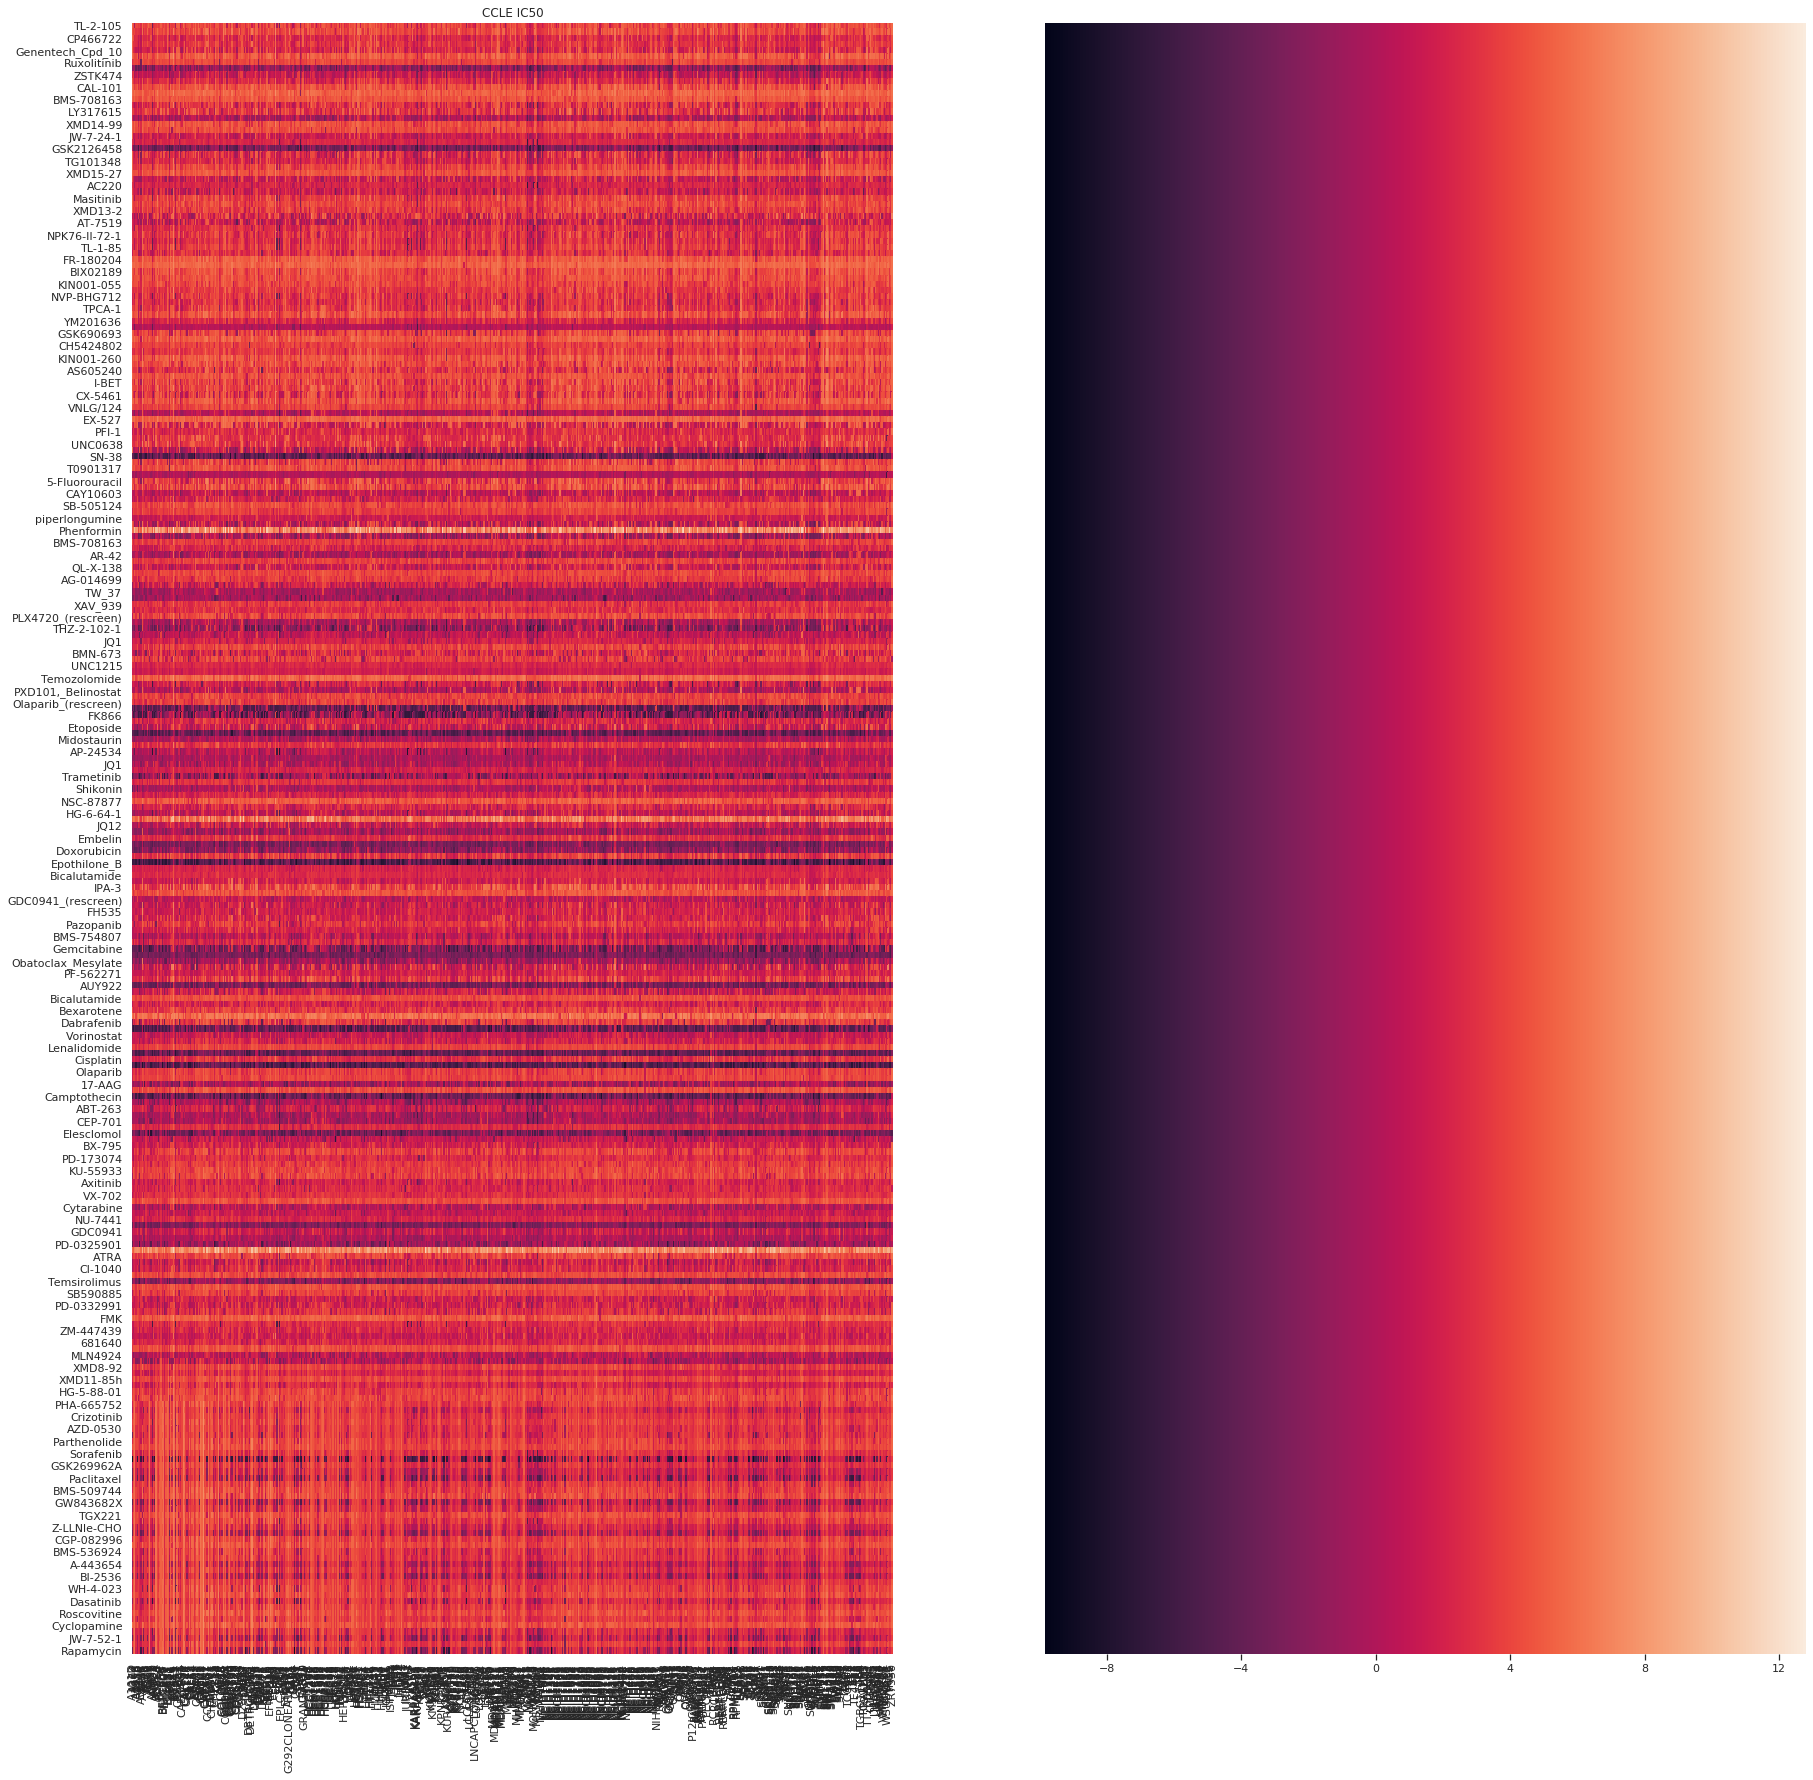

In [45]:
import matplotlib
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(30,30))


_min = IC50.min().min() #-8
_max = IC50.max().max() #12


sns.heatmap(IC50.transpose(), vmin=_min, vmax=_max, ax = axs[0],cbar=True, xticklabels=True, cbar_ax = axs[1],cbar_kws={"orientation": "horizontal"}).set_title('CCLE IC50')


In [24]:
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif
from scipy import stats

#F, p = stats.f_oneway(d_data['ctrl'], d_data['trt1'], d_data['trt2'])
y = IC50.to_numpy().mean(axis = 1)
X = E_CCLE_norm.to_numpy()[:,:]
print (X.shape, y.shape)

print("std variation in IC50 values across different drugs")
s1 = IC50.to_numpy().std(axis = 1).mean()
print (s1)
print("std variation in IC50 values across different samples")
s0 = IC50.to_numpy().std(axis = 0).mean()
print (s0)

print("anova test for the effect of a set of different drugs on IC50 value")
s = IC50.to_numpy()
f_anova, p_anova = stats.f_oneway(s[:,0],s[:,1], s[:,2],s[:,3],s[:,4],s[:,5],s[:,6],s[:,7],s[:,8],s[:,9],s[:,10],s[:,11])
print( f_anova, p_anova)

print("anova test for the effect of a set of different samples on IC50 value")
s = IC50.to_numpy()
f_anova, p_anova = stats.f_oneway(s[0,:], s[1,:],s[3,:],s[2,:],s[4,:],s[5,:], s[6,:], s[7,:],s[8,:],s[9,:],s[10,:],s[11,:] )
print( f_anova, p_anova)

(610, 17947) (610,)
std variation in IC50 values across different drugs
2.4667730368197143
std variation in IC50 values across different samples
1.398635596811755
anova test for the effect of a set of different drugs on IC50 value
1199.9801613177567 0.0
anova test for the effect of a set of different samples on IC50 value
15.136701904885333 4.095354918272438e-29


In [25]:
X = E_CCLE_norm
X[(X == 0.0)] = 0.00001 #replace 0 by 0.00001 to avoid errors from dividing by 0

In [26]:
#gene expression covariance
fn = "gene_exp_corr.feather"
if os.path.exists(fn):
    print(True)
    corr = pd.read_feather(fn)
    corr.set_index('index', inplace=True)
    del corr.index.name
    
else:    
    corr = X.iloc[:,:].corr() 
    corr.reset_index().to_feather(fn)

True


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
s = np.reshape(corr.to_numpy(), (corr.shape[0] * corr.shape[0]))

print(s.shape)

(322094809,)


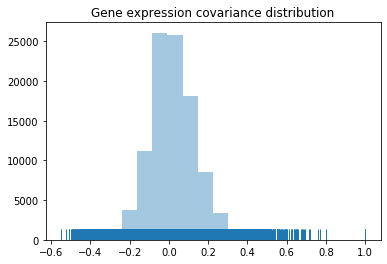

In [29]:
sns.distplot(s[:100000], bins=20, kde=False, rug=True).set_title("Gene expression covariance distribution");  #Reduced sample (representative) because of long process

In [35]:
#gene expression covariance matrix (sample)
_corr = corr.iloc[:100,:100]
_corr.style.background_gradient(cmap='coolwarm').set_precision(1)

In [49]:
# selection of genes based on linear association of gene expression on drug response  
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np


from sklearn.feature_selection import SelectKBest



X = E_CCLE_norm
X[(X == 0.0)] = 0.00001 #replace 0 by 0.00001 to avoid errors from dividing by 0
common_genes = []
for i,d in  enumerate(IC50.columns):
    y = IC50.to_numpy()[:,i]
    
    linear = SelectKBest(f_regression, k=5).fit(X, y)
    f = linear.get_support()
    print(d)
    selected = set(X.columns[f])
    np.set_printoptions(precision=1)
    print(X.columns[f], np.array(linear.scores_[f]))
    common_genes.extend(selected)
    
import collections
cou = collections.Counter(common_genes)
print("common genes")
print(cou)



Automatically created module for IPython interactive environment
TL-2-105
Index(['MYOF', 'PTPN7', 'RND3', 'SPN', 'WAS'], dtype='object') [233.3 255.3 226.6 227.1 238.7]
TAK-715
Index(['BCAR1', 'FKBP9', 'IKZF1', 'LAMB2', 'PARVA'], dtype='object') [196.6 192.6 193.3 190.  193.3]
CP466722
Index(['CTTN', 'IKZF1', 'NCKAP1L', 'PTPN7', 'WAS'], dtype='object') [176.8 177.3 178.3 179.4 176.1]
BMS-345541
Index(['BCAR1', 'IKZF1', 'ITGB5', 'PTPN7', 'WAS'], dtype='object') [195.2 202.6 189.3 190.9 198.6]
Genentech_Cpd_10
Index(['BAIAP2L1', 'CTTN', 'GPRC5A', 'PERP', 'WAS'], dtype='object') [161.8 150.1 148.4 146.9 146.8]
GSK429286A
Index(['PERP', 'PTPN7', 'SDC4', 'TMEM54', 'WAS'], dtype='object') [237.4 235.8 260.6 227.6 231.4]
Ruxolitinib
Index(['IKZF1', 'PTPN7', 'SPN', 'TJP1', 'WAS'], dtype='object') [180.9 190.2 181.7 184.5 198.2]
SB-715992
Index(['CTTN', 'MANBAL', 'PRSS23', 'SDC4', 'WAS'], dtype='object') [131.9 136.8 132.1 147.  129.9]
ZSTK474
Index(['CD53', 'CTTN', 'IKZF1', 'NCKAP1L', 'WAS'], 

NSC-207895
Index(['ABCC3', 'ANKLE1', 'ATP1B1', 'NQO1', 'SDC4'], dtype='object') [120.4 101.4 105.8 122.6 107.3]
CAY10603
Index(['BAIAP2L1', 'CEP170B', 'CTTN', 'PERP', 'PTPN7'], dtype='object') [157.7 147.7 158.1 158.5 142.6]
GSK269962A
Index(['B3GNT3', 'CLDN4', 'ESRP1', 'PRSS22', 'TMEM125'], dtype='object') [111.4 112.1 114.6 113.4 112.6]
SB-505124
Index(['ATP8B1', 'GPRC5A', 'KLF4', 'KRT19', 'MISP'], dtype='object') [ 93.   98.7  95.1 102.9 100.6]
Tamoxifen
Index(['ARHGAP15', 'CD53', 'IKZF1', 'WAS', 'WASL'], dtype='object') [117.  118.4 116.9 114.3 128.5]
piperlongumine
Index(['CEACAM5', 'CEACAM6', 'GPX2', 'PRR15L', 'TMEM45B'], dtype='object') [ 84.8  90.5  85.3  85.6 100. ]
PI-103
Index(['ABCC3', 'ANKLE1', 'ATP1B1', 'NQO1', 'PLCD3'], dtype='object') [138.1 139.2 141.3 137.6 138.2]
Phenformin
Index(['AMOTL2', 'GPC1', 'NR2F2', 'PTPN7', 'TJP1'], dtype='object') [110.3 124.9 107.3 107.9 109.8]
SNX-2112
Index(['GMFG', 'IKZF1', 'NCKAP1L', 'PTPN7', 'WAS'], dtype='object') [149.2 143.9 147.2 

Gemcitabine
Index(['OSBPL2', 'RAB22A', 'RNF103', 'SLFN11', 'TMEM86A'], dtype='object') [58.7 48.  54.  52.2 48.7]
Bryostatin_1
Index(['ARHGAP39', 'ATP1B1', 'DUSP8', 'EPHA10', 'GMFG'], dtype='object') [38.2 44.8 62.7 36.1 37.2]
Obatoclax_Mesylate
Index(['DUSP8', 'FAM177A1', 'MAPRE3', 'RNF103', 'ZBTB7C'], dtype='object') [63.  48.8 67.8 57.2 49.7]
Bleomycin
Index(['GADD45G', 'RNF103', 'SCG3', 'TMEM198', 'UNC80'], dtype='object') [37.5 35.  34.7 47.8 35.2]
PF-562271
Index(['FAM177A1', 'MAGIX', 'OSBPL2', 'RNF103', 'TTC39A'], dtype='object') [67.6 62.1 55.7 68.2 61.9]
GSK-650394
Index(['ANP32B', 'DNAJB2', 'HNRNPA1', 'LYAR', 'RNF103'], dtype='object') [53.  60.7 53.2 58.1 52.6]
AUY922
Index(['MAPRE3', 'OSBPL2', 'RNF103', 'TTC39A', 'UGT1A10'], dtype='object') [47.4 49.2 50.1 46.9 52.5]
RDEA119_(rescreen)
Index(['FOSL1', 'GKAP1', 'OAF', 'TIMP1', 'ZNF48'], dtype='object') [141.  122.6 123.1 121.7 119.3]
Bicalutamide
Index(['ANKLE1', 'IKZF1', 'KLHL6', 'TACC2', 'ZNF205'], dtype='object') [69.  74

NVP-TAE684
Index(['DDR1', 'KIAA1522', 'PPIC', 'PTPRF', 'RASAL3'], dtype='object') [133.9 138.1 133.7 132.7 137.7]
Crizotinib
Index(['IKZF1', 'PTPN7', 'RASAL3', 'SDC4', 'WAS'], dtype='object') [200.5 188.  194.1 185.5 196. ]
Imatinib
Index(['IKZF1', 'MYOF', 'PTPN7', 'SDC4', 'YAP1'], dtype='object') [214.1 210.6 224.9 217.3 210.2]
AZD-0530
Index(['ARHGAP15', 'CD53', 'IKZF1', 'NCKAP1L', 'PTPN7'], dtype='object') [115.2 118.1 120.3 116.3 118.2]
AZ628
Index(['GMFG', 'KIAA1522', 'NRROS', 'SPN', 'TUFT1'], dtype='object') [158.9 157.  175.1 164.5 165.6]
Parthenolide
Index(['IKZF1', 'KIAA1522', 'PPIC', 'SDC4', 'WAS'], dtype='object') [167.3 162.9 170.9 182.3 159.7]
KIN001-135
Index(['BCAR1', 'PPIC', 'RPL3', 'RPS9', 'SDC4'], dtype='object') [106.9 113.3 107.7 106.5 122.2]
Sorafenib
Index(['BCAR1', 'DDR1', 'IKZF1', 'NCKAP1', 'SDC4'], dtype='object') [175.4 173.9 177.7 174.5 172.1]
Bortezomib
Index(['KIAA1522', 'RHBDF1', 'SDC4', 'TNFRSF12A', 'YAP1'], dtype='object') [189.9 202.2 194.3 196.9 213.1]

In [37]:

#-------------------------------

print("regression test for the gene with maximal effect, from CCLE samples, on the mean IC50 value of all drugs")
f_test, p_test = f_regression(X,y)
print(f_test.shape)
l_am = np.argmax(f_test)
print(l_am)
print( f_test[l_am], p_test[l_am], E_CCLE_norm.columns[l_am])
f_test /= np.max(f_test)

print("MI test for the gene with maximal effect, from CCLE samples, on the mean IC50 value of all drugs")
#MI is a non-negative value, which measures the dependency between the variables.
#It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
mi = mutual_info_regression(X, y)
mi_am = np.argmax(mi)
print(mi_am)
print( mi[mi_am], E_CCLE_norm.columns[mi_am])
mi /= np.max(mi)





regression test for the gene with maximal effect, from CCLE samples, on the mean IC50 value of all drugs
(17947,)
7087
206.21014676012433 1.7731171151077268e-40 IKZF1
MI test for the gene with maximal effect, from CCLE samples, on the mean IC50 value of all drugs
6186
0.21352667602661857 GPRC5A


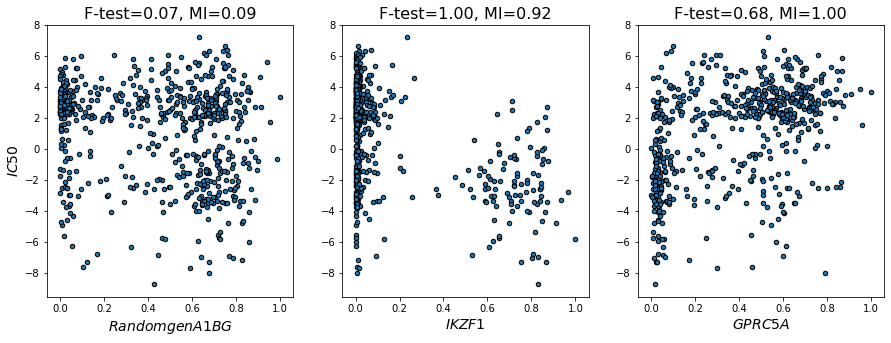

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6207857/  GPRC5A as a member of the largest family of protein targets for approved drugs -GPCRs-,is also a potential therapeutic target in patients with elevated GPRC5A levels.Its overexpression is associated with multiple drug resistance in several cancers


In [38]:
#plot selected genes against the mean IC50 value
random_gen = 0
selected_features =  [random_gen,l_am,mi_am]
plt.figure(figsize=(15, 5))
for i,f in enumerate(selected_features):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X.iloc[:, f], y, edgecolor='black', s=20)
    plt.xlabel("${}$".format(E_CCLE_norm.columns[f]), fontsize=14)
    if i == 0:
        plt.ylabel("$IC50$", fontsize=14)
        plt.xlabel("$Random gen {}$".format(E_CCLE_norm.columns[f]), fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[f], mi[f]),
              fontsize=16)
plt.show()

print("https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6207857/  GPRC5A as a member of the largest family of protein targets for approved drugs -GPCRs-,"+ 
      "is also a potential therapeutic target in patients with elevated GPRC5A levels."+ 
      "Its overexpression is associated with multiple drug resistance in several cancers")

Explore the number of gene expression patterns with largest covariance applying PCA (singular vector decomposition). The cumulative explained variance ratio could help for knowing how many dimensions are necessary to model gene expression reducing its dimension. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

90% of gene expression variance in CCLE samples is explained with 332 dimensions


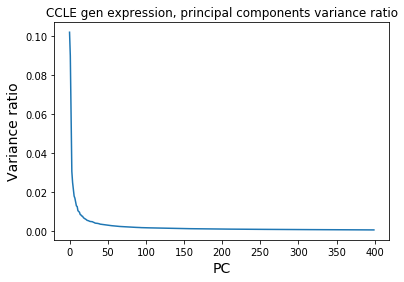

In [39]:
from sklearn.decomposition import PCA

#CCLE 
pca = PCA(n_components = 400).fit(X)
reduced_data = pca.transform(X)



import matplotlib.pyplot as plt
vr = pca.explained_variance_ratio_
cs = np.cumsum(vr)

n = np.where(cs >= 0.9)

print ("90% of gene expression variance in CCLE samples is explained with {} dimensions".format(n[0][0]) )

plt.plot(vr)
plt.title("CCLE gen expression, principal components variance ratio")
plt.ylabel("Variance ratio", fontsize=14)
plt.xlabel("PC", fontsize=14)
plt.show()

90% of gene expression variance in TCGA samples is explained with 708 dimensions


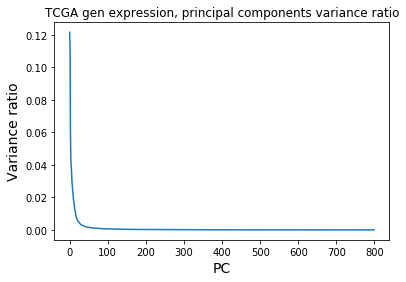

In [40]:
#TCGA
pca = PCA(n_components = 800).fit(E_TCGA)
reduced_data = pca.transform(E_TCGA)

vr = pca.explained_variance_ratio_
cs = np.cumsum(vr)

n = np.where(cs >= 0.9)

print ("90% of gene expression variance in TCGA samples is explained with {} dimensions".format(n[0][0]) )
plt.plot(vr)
plt.title("TCGA gen expression, principal components variance ratio")
plt.ylabel("Variance ratio", fontsize=14)
plt.xlabel("PC", fontsize=14)
plt.show()